In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




data_dir = 'Face Mask Dataset'

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
batch_size=64

# Create train, validation, and test datasets
train_dataset = datasets.ImageFolder('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/', transform=transform)
test_dataset = datasets.ImageFolder('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#  Integration of U-Net connections into the VAE architectures

In [2]:
class VAE_UNet(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_UNet, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = F.relu(self.encoder_conv3(x))
        x = F.relu(self.encoder_conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(-1, 256, 4, 4)
        x = F.relu(self.decoder_conv1(x))
        x = F.relu(self.decoder_conv2(x))
        x = F.relu(self.decoder_conv3(x))
        x = torch.sigmoid(self.decoder_conv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar
print("Hello")

Hello


# Plotting the training , validation loss vs epoch curve

In [3]:
def train_vae(vae, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    criterion = nn.BCELoss(reduction='sum')
    vae.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        vae.train()
        running_train_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            data = data[0].to(device)  # Since the dataset returns (image, label), we only need the image
            recon_batch, mu, logvar = vae(data)
            # Compute reconstruction loss and KL divergence
            loss = criterion(recon_batch, data)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss += kl_loss
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        vae.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                data = data[0].to(device)  # Since the dataset returns (image, label), we only need the image
                recon_batch, mu, logvar = vae(data)
                # Compute reconstruction loss and KL divergence
                loss = criterion(recon_batch, data)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss += kl_loss
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Plot the training and validation loss

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
print("Hello1")

Hello1


Epoch [1/10], Train Loss: 7667.8174, Val Loss: 7235.6158
Epoch [2/10], Train Loss: 7086.3795, Val Loss: 7031.1036
Epoch [3/10], Train Loss: 6962.9968, Val Loss: 6933.9984
Epoch [4/10], Train Loss: 6917.1508, Val Loss: 6893.6056
Epoch [5/10], Train Loss: 6886.4492, Val Loss: 6876.1023
Epoch [6/10], Train Loss: 6865.2152, Val Loss: 6866.8636
Epoch [7/10], Train Loss: 6852.1146, Val Loss: 6851.0272
Epoch [8/10], Train Loss: 6836.8421, Val Loss: 6836.9773
Epoch [9/10], Train Loss: 6827.9858, Val Loss: 6858.1317
Epoch [10/10], Train Loss: 6823.0401, Val Loss: 6821.7880


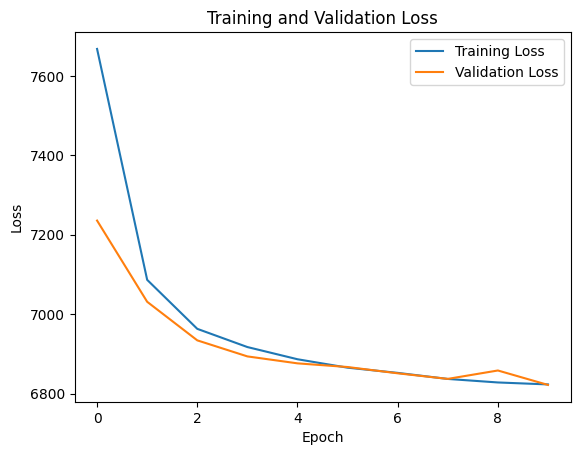

In [4]:
latent_dim = 80
vae = VAE_UNet(latent_dim).to(device)
train_losses, val_losses = train_vae(vae, train_loader, val_loader, num_epochs=10)
plot_loss(train_losses, val_losses)


# Comparison of the reconstruction ability of the VAE on input images of test set

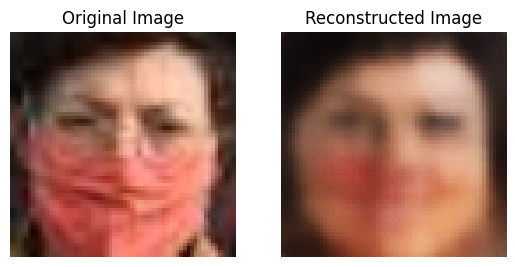

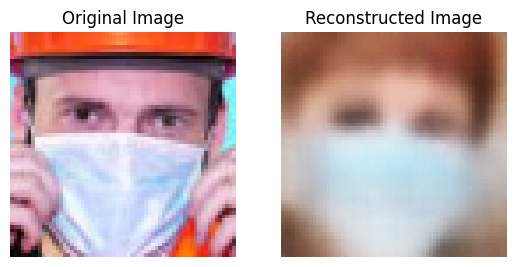

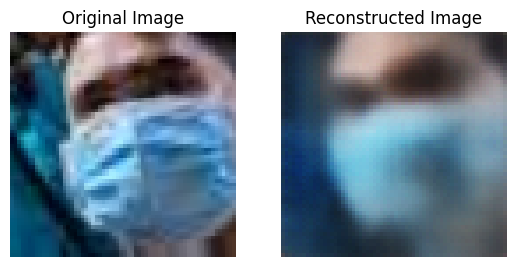

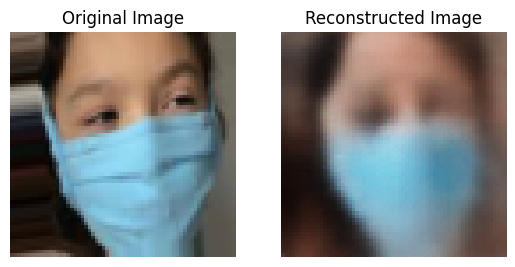

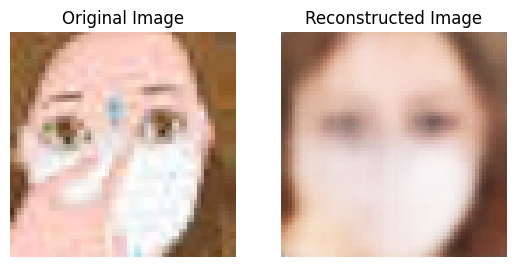

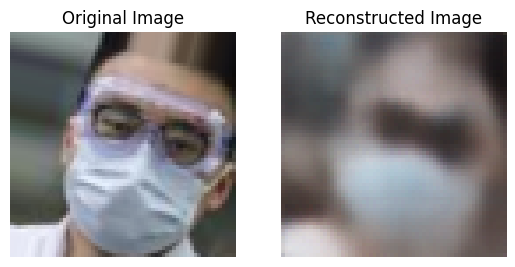

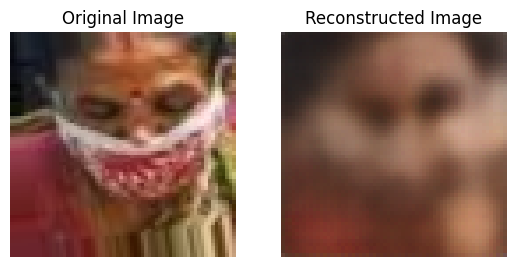

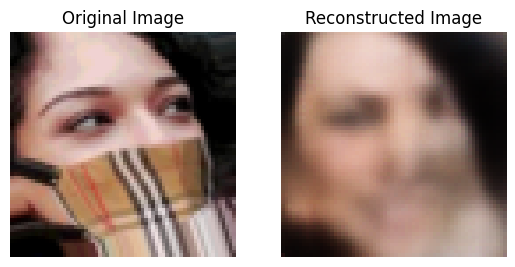

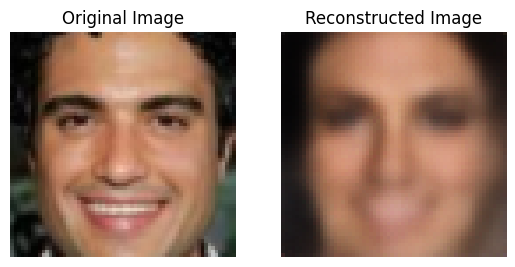

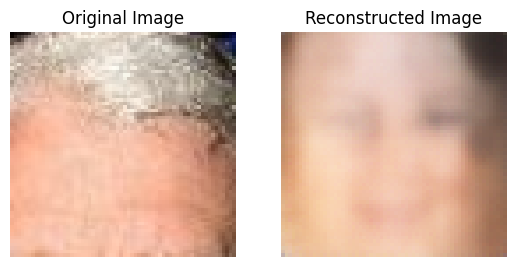

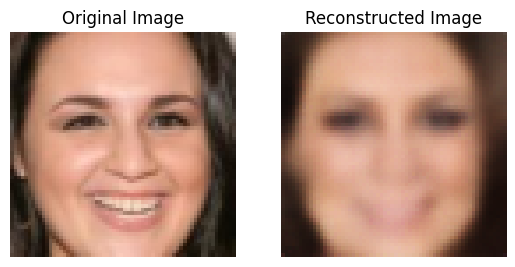

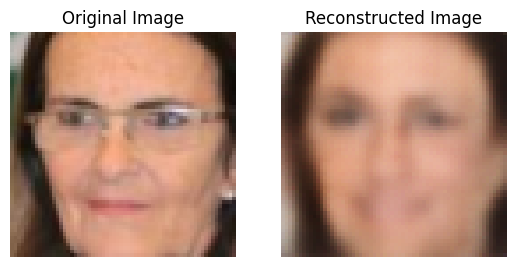

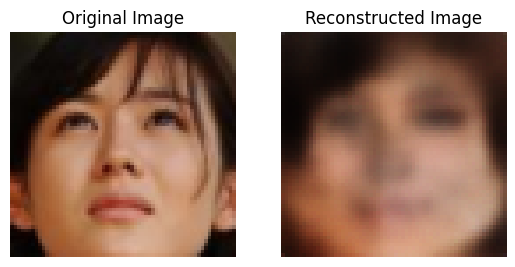

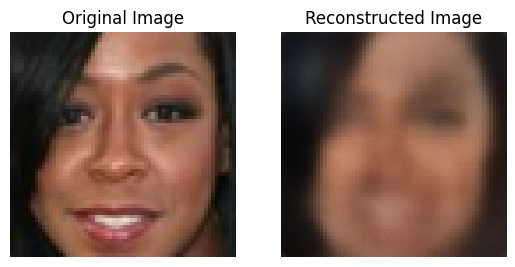

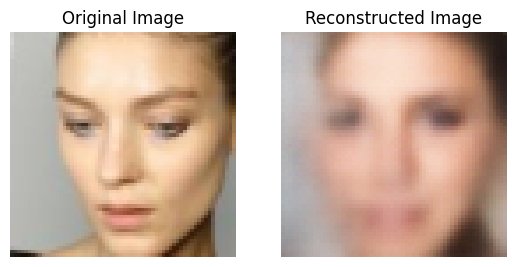

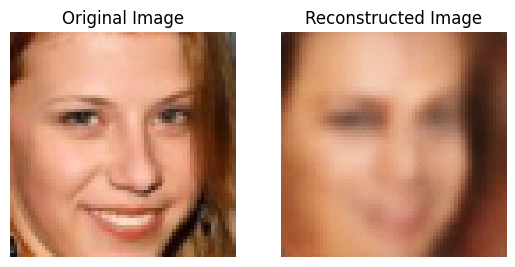

In [5]:
def compare_reconstruction(vae, test_loader):
    vae.eval()
    with torch.no_grad():
        for data in test_loader:
            data = data[0].to(device)
            recon_batch, _, _ = vae(data)
            
            # Convert tensors to numpy arrays
            original_imgs = data.cpu().numpy()
            recon_imgs = recon_batch.cpu().numpy()
            
            # Processing each image in the batch
            for original_img, recon_img in zip(original_imgs, recon_imgs):
                original_img = original_img.transpose((1, 2, 0))  # Change shape from (3, 64, 64) to (64, 64, 3)
                recon_img = recon_img.transpose((1, 2, 0))  # Change shape from (3, 64, 64) to (64, 64, 3)

                # Plot original and reconstructed images
                fig, axes = plt.subplots(1, 2)
                axes[0].imshow(original_img)
                axes[0].set_title('Original Image')
                axes[0].axis('off')
                axes[1].imshow(recon_img)
                axes[1].set_title('Reconstructed Image')
                axes[1].axis('off')
                plt.show()
                break


compare_reconstruction(vae, test_loader)


Randomly sampling a point from the latent space of the VAE and compare the output from the decoder with that of a normal autoencoder 

In [7]:
class AE_withUNet(nn.Module):
    def __init__(self, latent_dim):
        super(AE_withUNet, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = F.relu(self.encoder_conv3(x))
        x = F.relu(self.encoder_conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        return mu

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(-1, 256, 4, 4)
        x = F.relu(self.decoder_conv1(x))
        x = F.relu(self.decoder_conv2(x))
        x = F.relu(self.decoder_conv3(x))
        x = torch.sigmoid(self.decoder_conv4(x))
        return x

    def forward(self, x):
        mu = self.encode(x)
        reconstructed_x = self.decode(mu)
        return reconstructed_x
print("Hello")

Hello


In [8]:

ae = AE_withUNet(latent_dim=80).to(device)  # Move AE to GPU



In [9]:
def train_ae(ae, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = optim.Adam(ae.parameters(), lr=learning_rate)
    criterion = nn.BCELoss(reduction='sum')
    ae.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        ae.train()
        running_train_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            data = data[0].to(device)  # Since the dataset returns (image, label), we only need the image
            recon_batch = ae(data)
            loss = criterion(recon_batch, data)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        ae.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                data = data[0].to(device)  # Since the dataset returns (image, label), we only need the image
                recon_batch = ae(data)
                loss = criterion(recon_batch, data)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Training the normal autoencoder
ae_train_losses, ae_val_losses = train_ae(ae, train_loader, val_loader, num_epochs=10)


Epoch [1/10], Train Loss: 7544.3129, Val Loss: 7111.9244
Epoch [2/10], Train Loss: 6961.9740, Val Loss: 6857.5255
Epoch [3/10], Train Loss: 6821.2979, Val Loss: 6783.3496
Epoch [4/10], Train Loss: 6760.1256, Val Loss: 6737.5142
Epoch [5/10], Train Loss: 6727.4698, Val Loss: 6718.4599
Epoch [6/10], Train Loss: 6701.9477, Val Loss: 6695.2617
Epoch [7/10], Train Loss: 6690.5204, Val Loss: 6683.5386
Epoch [8/10], Train Loss: 6674.2922, Val Loss: 6671.0807
Epoch [9/10], Train Loss: 6664.0916, Val Loss: 6715.5489
Epoch [10/10], Train Loss: 6659.6516, Val Loss: 6653.4264


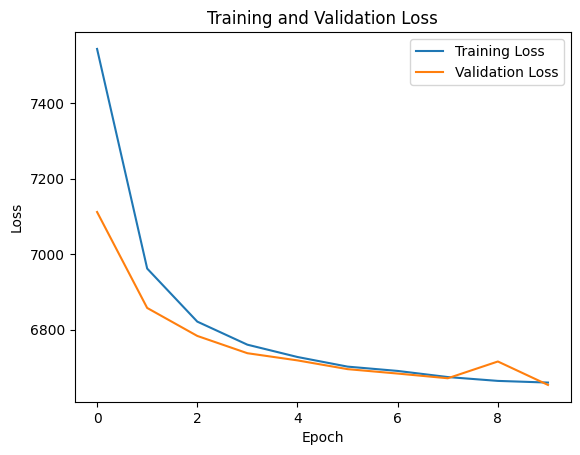

In [10]:
plot_loss(ae_train_losses, ae_val_losses)

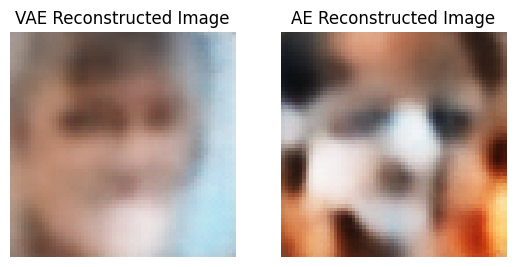

In [62]:
import matplotlib.pyplot as plt

def compare_decoded_outputs(vae, ae, test_loader, latent_dim, num_samples=1):
    vae.eval()
    ae.eval()
    
    with torch.no_grad():
        for i in range(num_samples):
            # Sample random latent vectors from VAE
            z_vae = torch.randn(1, latent_dim).to(device)
            
            # Sample random latent vectors from AE
            z_ae = torch.randn(1, latent_dim).to(device)
            
            # Decode latent vectors using VAE
            vae_output = vae.decode(z_vae)
            vae_output_img = vae_output.squeeze().cpu().numpy().transpose(1, 2, 0)
            
            # Decode latent vectors using AE
            ae_output = ae.decode(z_ae)
            ae_output_img = ae_output.squeeze().cpu().numpy().transpose(1, 2, 0)
            
            # Plotting
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(vae_output_img)
            axes[0].set_title('VAE Reconstructed Image')
            axes[0].axis('off')
            
            axes[1].imshow(ae_output_img)
            axes[1].set_title('AE Reconstructed Image')
            axes[1].axis('off')
            
            plt.show()

# Example usage
compare_decoded_outputs(vae, ae, test_loader, latent_dim=80, num_samples=1)


# Plotting the t-SNE plot of VAE and comparison with normal autoencoder

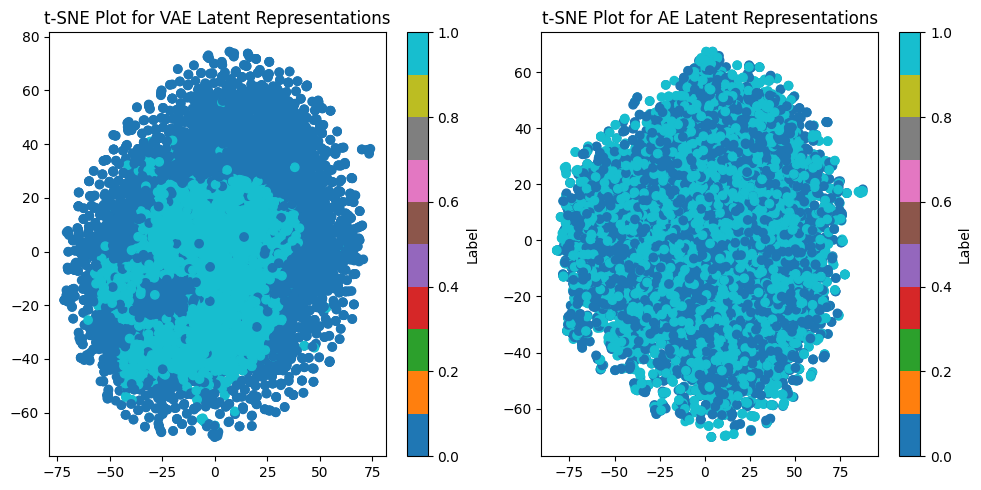

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(vae, ae, train_loader, latent_dim):
    # Extracting latent representations for training data (VAE)
    train_latents_vae = []
    train_labels = []
    with torch.no_grad():
        for data, labels in train_loader:
            data = data.to(device)
            mu, _ = vae.encode(data)
            train_latents_vae.append(mu.cpu().numpy())
            train_labels.append(labels.numpy())
    train_latents_vae = np.concatenate(train_latents_vae, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Extracting latent representations for training data (AE)
    train_latents_ae = []
    with torch.no_grad():
        for data, _ in train_loader:
            data = data.to(device)
            latents = ae.encode(data)
            train_latents_ae.append(latents.cpu().numpy())
    train_latents_ae = np.concatenate(train_latents_ae, axis=0)
    
    # Performing t-SNE on VAE latent representations
    tsne_vae = TSNE(n_components=2, random_state=42)
    tsne_embeddings_vae = tsne_vae.fit_transform(train_latents_vae)
    
    # Performing t-SNE on AE latent representations
    tsne_ae = TSNE(n_components=2, random_state=42)
    tsne_embeddings_ae = tsne_ae.fit_transform(train_latents_ae)
    
    # Plotting t-SNE embeddings
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(tsne_embeddings_vae[:, 0], tsne_embeddings_vae[:, 1], c=train_labels, cmap='tab10')
    plt.title('t-SNE Plot for VAE Latent Representations')
    plt.colorbar(label='Label')
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_embeddings_ae[:, 0], tsne_embeddings_ae[:, 1], c=train_labels, cmap='tab10')
    plt.title('t-SNE Plot for AE Latent Representations')
    plt.colorbar(label='Label')
    plt.tight_layout()
    plt.show()


plot_tsne(vae, ae, train_loader, latent_dim=80)


# Smoothness of Latent Space

Evaluating Smoothness Graphically

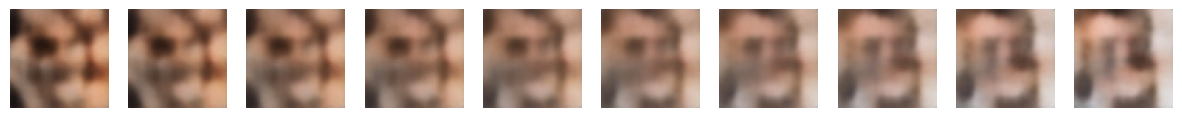

In [16]:
def interpolate_latent_space(vae, latent_dim, num_interpolations=10):
    vae.eval()
    with torch.no_grad():
        z1 = torch.randn(1, latent_dim).to(device)
        z2 = torch.randn(1, latent_dim).to(device)
        interpolations = []
        for alpha in np.linspace(0, 1, num_interpolations):
            interpolated_z = alpha * z1 + (1 - alpha) * z2
            interpolations.append(interpolated_z)
        interpolated_outputs = []
        for z in interpolations:
            output = vae.decode(z)
            interpolated_outputs.append(output)
        fig, axes = plt.subplots(1, num_interpolations, figsize=(15, 3))
        for i, output in enumerate(interpolated_outputs):
            axes[i].imshow(output.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
            axes[i].axis('off')
        plt.show()

# Example usage
interpolate_latent_space(vae, latent_dim)

Evaluating smoothness mathematically

In [24]:
import torch.nn.functional as F

def interpolate_latent_space(vae, latent_dim, num_interpolations=10):
    vae.eval()
    with torch.no_grad():
        z1 = torch.randn(1, latent_dim).to(device)
        z2 = torch.randn(1, latent_dim).to(device)
        interpolations = []
        distances = []
        for alpha in np.linspace(0, 1, num_interpolations):
            interpolated_z = alpha * z1 + (1 - alpha) * z2
            interpolations.append(interpolated_z)
        for i in range(len(interpolations) - 1):
            distance = F.pairwise_distance(interpolations[i], interpolations[i+1])
            distances.append(distance.item())
        mean_distance = sum(distances) / len(distances)
        print("Mean distance between consecutive interpolated latent vectors:", mean_distance)

# Example usage
interpolate_latent_space(vae, latent_dim)


Mean distance between consecutive interpolated latent vectors: 1.387418058183458


# Taking the latent representation of VAE and evaluating its performance on classification task and also compare this with a regular autoencoder

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def evaluate_latent_representation(vae, ae, train_loader, test_loader, latent_dim, classifier='svm'):
    vae.eval()
    ae.eval()
    
    # Extracting latent representations for training data (VAE)
    train_latents_vae = []
    train_labels = []
    with torch.no_grad():
        for data, labels in train_loader:
            data = data.to(device)
            _, mu, _ = vae(data)
            train_latents_vae.append(mu.cpu().numpy())
            train_labels.append(labels.numpy())
    train_latents_vae = np.concatenate(train_latents_vae, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Extracting latent representations for test data (VAE)
    test_latents_vae = []
    test_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            _, mu, _ = vae(data)
            test_latents_vae.append(mu.cpu().numpy())
            test_labels.append(labels.numpy())
    test_latents_vae = np.concatenate(test_latents_vae, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    
    # Extracting latent representations for training data (AE)
    train_latents_ae = []
    with torch.no_grad():
        for data, _ in train_loader:
            data = data.to(device)
            latents = ae.encode(data)
            train_latents_ae.append(latents.cpu().numpy())
    train_latents_ae = np.concatenate(train_latents_ae, axis=0)
    
    # Extracting latent representations for test data (AE)
    test_latents_ae = []
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            latents = ae.encode(data)
            test_latents_ae.append(latents.cpu().numpy())
    test_latents_ae = np.concatenate(test_latents_ae, axis=0)
    
    # Training a classifier using the latent representations (VAE)
    if classifier == 'svm':
        clf_vae = SVC(kernel='linear')
    else:
        # Default to SVM if classifier is not specified
        clf_vae = SVC(kernel='linear')
        
    clf_vae.fit(train_latents_vae, train_labels)
    
    # Training a classifier using the latent representations (AE)
    if classifier == 'svm':
        clf_ae = SVC(kernel='linear')
    else:
        # Default to SVM if classifier is not specified
        clf_ae = SVC(kernel='linear')
        
    clf_ae.fit(train_latents_ae, train_labels)
    
    # Evaluate the classifier's performance (VAE)
    train_preds_vae = clf_vae.predict(train_latents_vae)
    train_accuracy_vae = accuracy_score(train_labels, train_preds_vae) * 100
    
    test_preds_vae = clf_vae.predict(test_latents_vae)
    test_accuracy_vae = accuracy_score(test_labels, test_preds_vae) * 100
    
    print("VAE Training Accuracy: {:.2f}%".format(train_accuracy_vae))
    print("VAE Test Accuracy: {:.2f}%".format(test_accuracy_vae))
    
    # Evaluate the classifier's performance (AE)
    train_preds_ae = clf_ae.predict(train_latents_ae)
    train_accuracy_ae = accuracy_score(train_labels, train_preds_ae) * 100
    
    test_preds_ae = clf_ae.predict(test_latents_ae)
    test_accuracy_ae = accuracy_score(test_labels, test_preds_ae) * 100
    
    print("AE Training Accuracy: {:.2f}%".format(train_accuracy_ae))
    print("AE Test Accuracy: {:.2f}%".format(test_accuracy_ae))

# Example usage
evaluate_latent_representation(vae, ae, train_loader, test_loader, latent_dim=80, classifier='svm')


VAE Training Accuracy: 94.07%
VAE Test Accuracy: 93.45%
AE Training Accuracy: 53.70%
AE Test Accuracy: 63.91%


# How can one improve the VAE's ability to generate high fidelity and diverse samples

Improving the ability of a Variational Autoencoder (VAE) to generate high-fidelity and diverse samples can be approached from several angles. Here are some strategies:

**Architecture Design:**
Experiment with different architectures, such as increasing the depth or width of the encoder and decoder networks. This can allow the model to learn more complex representations of the data.
Use more sophisticated architectures like convolutional or recurrent VAEs, which are particularly effective for image or sequential data, respectively.
Consider using more advanced techniques such as residual connections, skip connections, or attention mechanisms to enhance information flow and capture long-range dependencies.

**Latent Space Design:**
Increase the dimensionality of the latent space. Higher-dimensional latent spaces can potentially capture more intricate structures in the data, leading to richer representations and better sample quality.
Use non-Gaussian distributions for the latent variables. While the standard VAE uses a Gaussian distribution, using more flexible distributions such as mixture models or flow-based distributions can enable the model to capture more complex data distributions.

**Loss Function Modifications:**
Experiment with alternative divergence measures such as the Wasserstein distance or MMD (Maximum Mean Discrepancy), which may provide better training stability and lead to improved sample quality.
Introduce additional regularization terms to encourage diversity in the latent space, such as enforcing sparsity or incorporating a clustering objective.

**Training Techniques:**
Employ advanced training techniques such as curriculum learning, where the model is first trained on simpler examples before moving to more complex ones. This can help stabilize training and improve sample diversity.
Utilize techniques like scheduled sampling or teacher forcing, which gradually introduce the model to its own generated samples during training. This can prevent mode collapse and encourage exploration of the entire data distribution.

**Data Augmentation:**
Augment the training data with various transformations (e.g., rotations, translations, scaling) to expose the model to a wider range of data variations. This can help the model learn more robust and diverse representations.
Incorporate domain-specific knowledge into the data augmentation process to ensure that the generated samples are realistic and semantically meaningful.

**Regularization:**
Apply regularization techniques such as dropout or weight decay to prevent overfitting and encourage the model to learn more generalizable features.
Use techniques like adversarial training, where a discriminator is trained to distinguish between real and generated samples, to encourage the generator to produce more realistic samples.

**Evaluation and Feedback:**
Continuously evaluate the quality of generated samples using both quantitative metrics (e.g., FID score, Inception score) and qualitative assessments by human evaluators. This feedback can guide further improvements to the model architecture and training process.

In [28]:
def improved_vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


The **improved_vae_loss** function is different from a normal VAE loss in that it explicitly includes both the Binary Cross Entropy (BCE) loss and the Kullback-Leibler Divergence (KLD) loss terms. While a standard VAE loss typically includes only the KLD term alongside the reconstruction loss (BCE), the improved loss emphasizes both reconstruction fidelity and latent space regularization. This can lead to more robust and well-structured latent representations, improving the generative capabilities and interpretability of the VAE model.

Epoch: 0, Train Loss: 7609.6680, Val Loss: 7250.1099
Epoch: 1, Train Loss: 7067.5384, Val Loss: 7005.4614
Epoch: 2, Train Loss: 6951.0596, Val Loss: 6916.8472
Epoch: 3, Train Loss: 6905.3361, Val Loss: 6953.9439
Epoch: 4, Train Loss: 6881.8405, Val Loss: 6860.3888
Epoch: 5, Train Loss: 6857.0667, Val Loss: 6859.1106
Epoch: 6, Train Loss: 6842.2610, Val Loss: 6836.7951
Epoch: 7, Train Loss: 6831.8670, Val Loss: 6829.2172
Epoch: 8, Train Loss: 6825.8310, Val Loss: 6824.0824
Epoch: 9, Train Loss: 6816.4926, Val Loss: 6815.7283


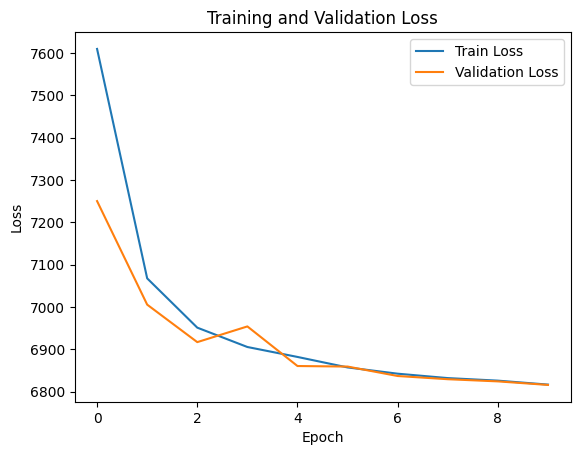

In [29]:
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image

# Step 11: Improve VAE's ability to generate high fidelity and diverse samples

class ImprovedVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ImprovedVAE, self).__init__()
        
        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = F.relu(self.encoder_conv3(x))
        x = F.relu(self.encoder_conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(-1, 256, 4, 4)
        x = F.relu(self.decoder_conv1(x))
        x = F.relu(self.decoder_conv2(x))
        x = F.relu(self.decoder_conv3(x))
        x = torch.sigmoid(self.decoder_conv4(x))
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# Example usage
latent_dim = 80
improved_vae = ImprovedVAE(latent_dim).to(device)
import matplotlib.pyplot as plt

def train_improved_vae(vae, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    train_losses = []
    val_losses = []
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        vae.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = improved_vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon_batch, mu, logvar = vae(data)
                val_loss += improved_vae_loss(recon_batch, data, mu, logvar).item()
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)
        
        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, train_loss, val_loss))
    
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage
train_improved_vae(improved_vae, train_loader, val_loader, num_epochs=10, learning_rate=1e-3)
